# Class Workbook {.tabset .tabset-fade .tabset-pills}

In [1]:
# Global parameter
show_code <- TRUE

In [2]:
knitr::opts_chunk$set(echo = TRUE,message=FALSE,fig.align="center",fig.width=7,fig.height=2.5)
pacman::p_load(
       car
      , ggplot2
      , ggExtra
      , reshape2
      , corrplot
      , RColorBrewer
      , lubridate
      , AmesHousing
      )

## In class activity

### Ames Housing data

Please take a look at the Ames Hoursing data.

In [3]:
library(AmesHousing)
?ames_raw

The goal of this exercise is to predict the price of the house.

Here is a histogram of the sales price with red line showing the mean.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  12789  129500  160000  180796  213500  755000 

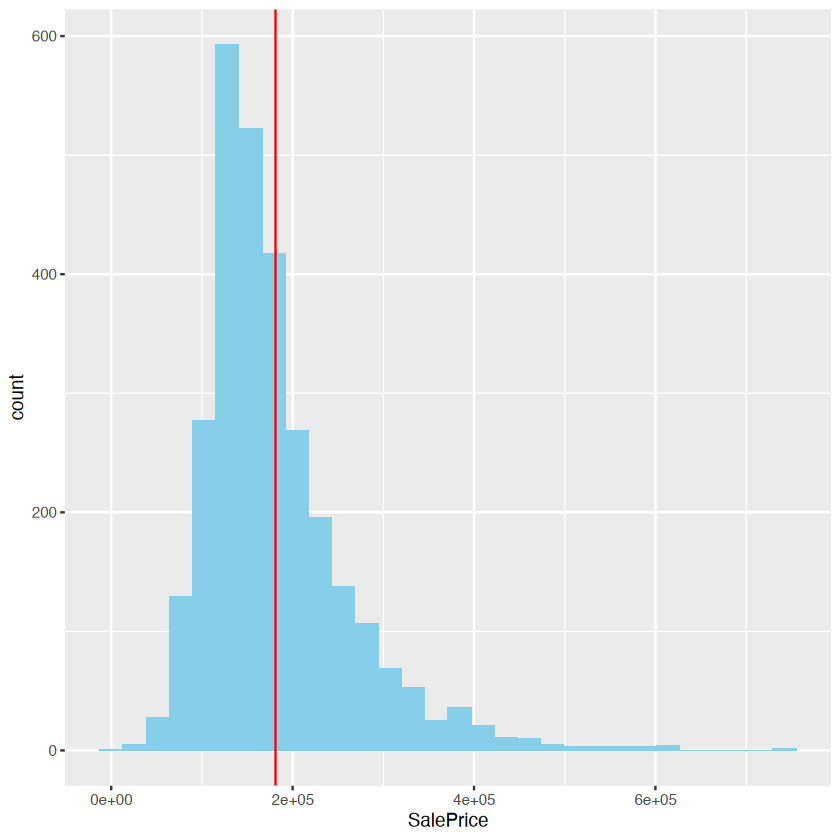

In [4]:
ggplot(ames_raw)+geom_histogram(fill="skyblue")+aes(x=SalePrice)+
  geom_vline(xintercept = mean(ames_raw$SalePrice),col="red")
summary(ames_raw$SalePrice)

Initial linear model without a predictor

In [5]:
lmfit_null<- lm(SalePrice~1,ames_raw)
summary(lmfit_null)


Call:
lm(formula = SalePrice ~ 1, data = ames_raw)

Residuals:
    Min      1Q  Median      3Q     Max 
-168007  -51296  -20796   32704  574204 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   180796       1476   122.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 79890 on 2929 degrees of freedom


How good is this result?  Let's look at RMSE.

In [6]:
sqrt(mean(residuals(lmfit_null)^2))

[1] 79873.06

Since the price is right skewed lets log transformation the outcome

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


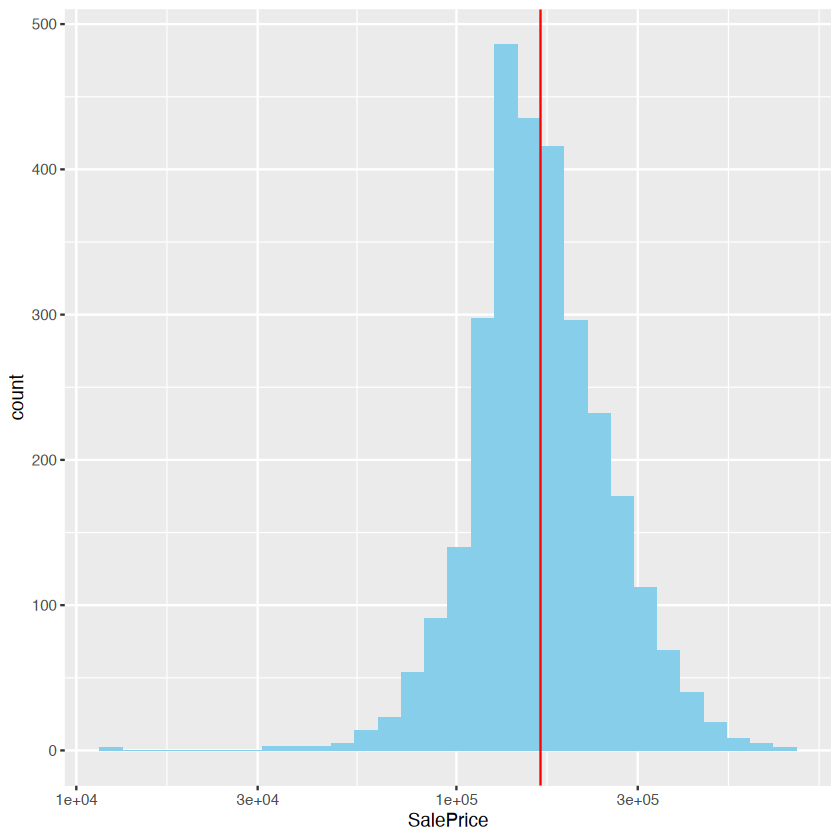

In [7]:
ggplot(ames_raw)+geom_histogram(fill="skyblue")+aes(x=SalePrice)+geom_vline(xintercept = exp(mean(log(ames_raw$SalePrice))),col="red")+scale_x_log10()

Fitting the same model on the log transformed outcome

In [8]:
lmfit_null_log<- lm(log(SalePrice)~1,ames_raw)
summary(lmfit_null_log)


Call:
lm(formula = log(SalePrice) ~ 1, data = ames_raw)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.56463 -0.24953 -0.03804  0.25042  1.51350 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 12.02097    0.00753    1596   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4076 on 2929 degrees of freedom


RMSE is

In [9]:
sqrt(mean((ames_raw$SalePrice-exp(predict(lmfit_null_log)))^2))

[1] 81195.11

Notice that the RMSE is actually bigger with log transformed model.
So should we not transform?  What do we get from the transformation?

Here is the prediction uncertainty overlayed on the histogram.

Warning message in predict.lm(lmfit_null, interval = "prediction"):
“predictions on current data refer to _future_ responses
”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


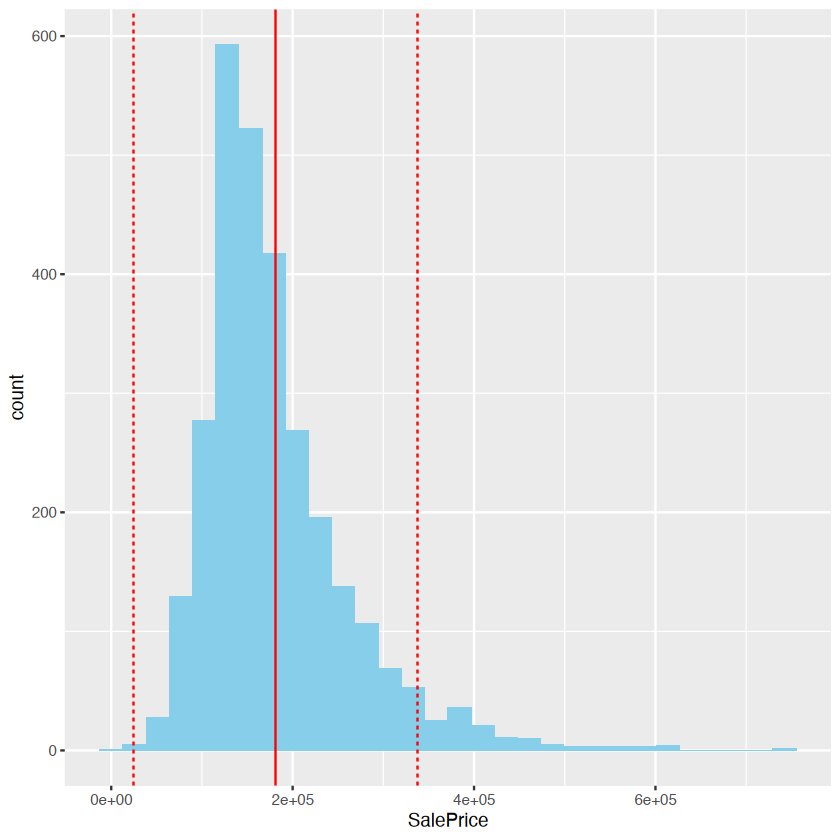

In [10]:
intpred=predict(lmfit_null,interval="prediction")
ggplot(ames_raw)+geom_histogram(fill="skyblue")+aes(x=SalePrice)+geom_vline(xintercept = mean(ames_raw$SalePrice),col="red")+geom_vline(xintercept = intpred[1,2],col="red",lty=2)+geom_vline(xintercept = intpred[1,3],col="red",lty=2)

Warning message in predict.lm(lmfit_null_log, interval = "prediction"):
“predictions on current data refer to _future_ responses
”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


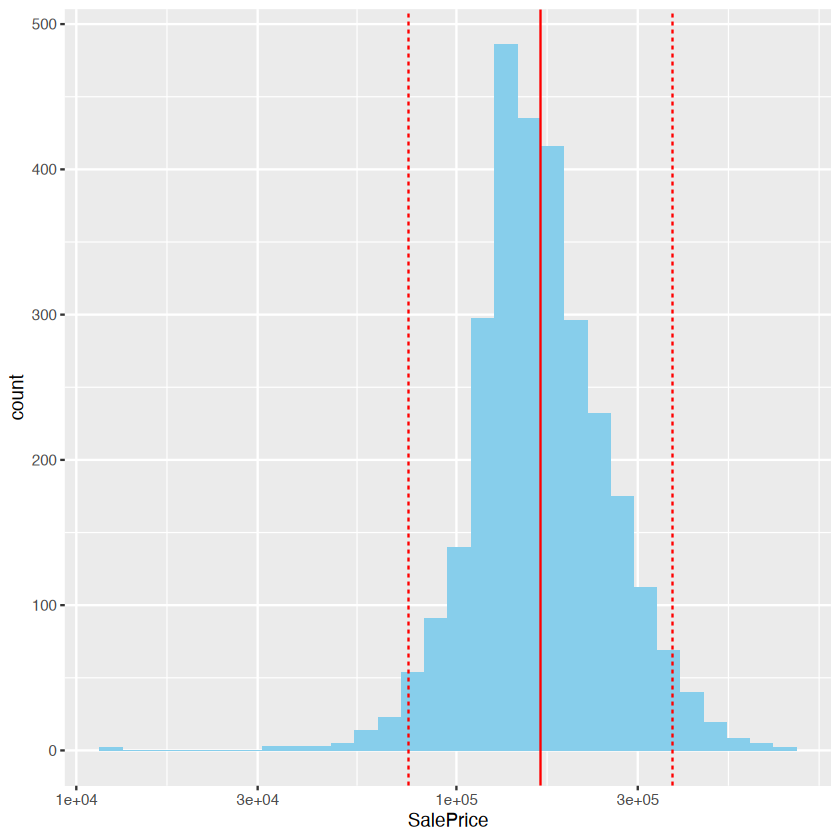

In [11]:
intpredlog=predict(lmfit_null_log,interval="prediction")
ggplot(ames_raw)+geom_histogram(fill="skyblue")+aes(x=SalePrice)+geom_vline(xintercept = exp(mean(log(ames_raw$SalePrice))),col="red")+scale_x_log10()+
  geom_vline(xintercept = exp(intpredlog[1,2]),col="red",lty=2)+
  geom_vline(xintercept = exp(intpredlog[1,3]),col="red",lty=2)

The log model seem to have a better uncertainty estimate.  What good does that do?

Let’s say the model is for an algorithm that buys the house.  If you pay more than the true price the company buys. If the price is lower, then the company fails to buy.
- If you bought for more than the true value you’ve over paid.
- If you bid less and lost, you lost a profit of the 10% of the house price.

Based on such loss function what is our overall loss if we base our decision on this model?

In [12]:
allres<-residuals(lmfit_null)
abs(sum(allres[allres<0]))+sum(0.1*(coef(lmfit_null)+allres[allres>0]))

[1] 114215680

In [13]:
allreslog<-ames_raw$SalePrice-exp(predict(lmfit_null_log))
abs(sum(allreslog[allreslog<0]))+sum(0.1*(exp(coef(lmfit_null_log))+allreslog[allreslog>0]))

[1] 94211655

As you can see with a better calibrated model you have a better performance for more realistic loss.

### Adding predictor `Gr Liv Area`

We add a predictor `Gr Liv Area`

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


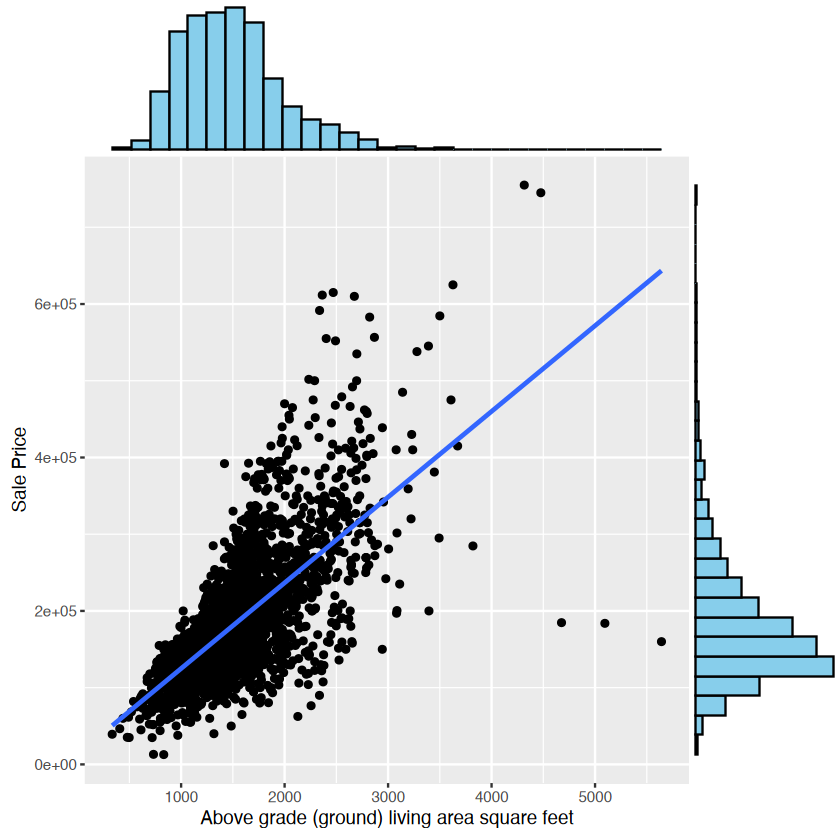

In [14]:
p=ggplot(ames_raw)+geom_point()+aes(x=`Gr Liv Area`,y=SalePrice)+xlab("Above grade (ground) living area square feet")+ylab("Sale Price")+geom_smooth(method="lm",se=FALSE)
p3 <- ggMarginal(p, margins = 'both', fill="skyblue", size=4,type="histogram")
p3

Using `Gr Liv Area` as predictor

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `get()`:
! object 'rlm' of mode 'function' was not found”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `get()`:
! object 'rlm' of mode 'function' was not found”
`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Computation failed in `stat_smooth()`
Caused by error in `get()`:
! object 'rlm' of mode 'function' was not found”


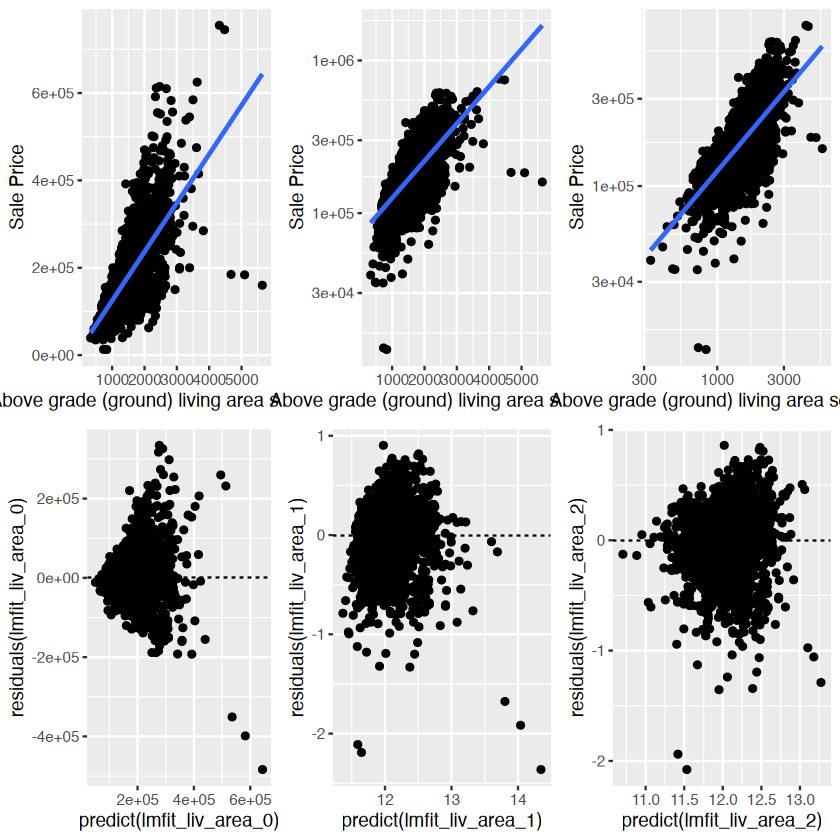

In [15]:
lmfit_liv_area_0<- lm(SalePrice~`Gr Liv Area`,ames_raw)
lmfit_liv_area_1<- lm(log(SalePrice)~`Gr Liv Area`,ames_raw)
lmfit_liv_area_2<- lm(log(SalePrice)~log(`Gr Liv Area`),ames_raw)
gridExtra::grid.arrange(
ggplot(ames_raw)+geom_point()+aes(x=`Gr Liv Area`,y=SalePrice)+xlab("Above grade (ground) living area square feet")+ylab("Sale Price")+geom_smooth(method="lm",se=FALSE),
ggplot(ames_raw)+geom_point()+aes(x=`Gr Liv Area`,y=SalePrice)+xlab("Above grade (ground) living area square feet")+ylab("Sale Price")+geom_smooth(method="lm",se=FALSE)+scale_y_log10(),
ggplot(ames_raw)+geom_point()+aes(x=`Gr Liv Area`,y=SalePrice)+xlab("Above grade (ground) living area square feet")+ylab("Sale Price")+geom_smooth(method="lm",se=FALSE)+scale_y_log10()+scale_x_log10(),
qplot(predict(lmfit_liv_area_0),residuals(lmfit_liv_area_0))+geom_smooth(method="rlm")+geom_hline(yintercept = 0,lty=2),
qplot(predict(lmfit_liv_area_1),residuals(lmfit_liv_area_1))+geom_smooth(method="rlm")+geom_hline(yintercept = 0,lty=2),
qplot(predict(lmfit_liv_area_2),residuals(lmfit_liv_area_2))+geom_smooth(method="rlm")+geom_hline(yintercept = 0,lty=2),
ncol=3
)

Because of the skewness it's better to take log on both x and y.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


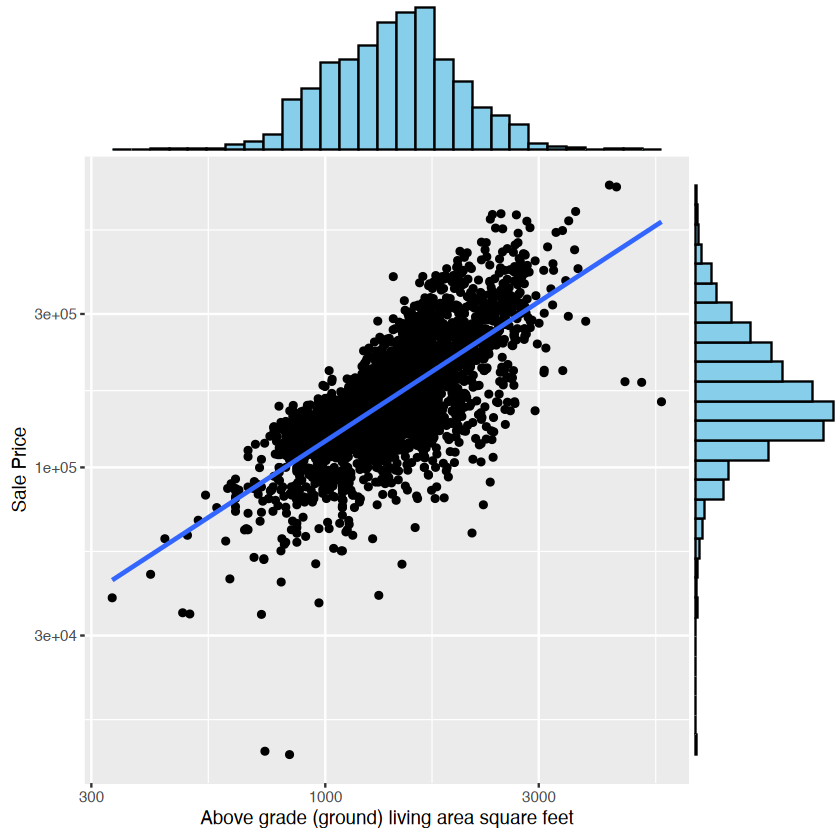

In [16]:
p=ggplot(ames_raw)+geom_point()+aes(x=`Gr Liv Area`,y=SalePrice)+xlab("Above grade (ground) living area square feet")+ylab("Sale Price")+geom_smooth(method="lm",se=FALSE)+scale_y_log10()+scale_x_log10()
p3 <- ggMarginal(p, margins = 'both', fill="skyblue", size=4,type="histogram")
p3

In [17]:
lm_mod_1 <- lm(log(SalePrice)~log(`Gr Liv Area`),ames_raw)
summary(lm_mod_1)


Call:
lm(formula = log(SalePrice) ~ log(`Gr Liv Area`), data = ames_raw)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0778 -0.1465  0.0264  0.1740  0.8602 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)         5.43019    0.11644   46.63   <2e-16 ***
log(`Gr Liv Area`)  0.90781    0.01602   56.66   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2816 on 2928 degrees of freedom
Multiple R-squared:  0.523,	Adjusted R-squared:  0.5228 
F-statistic:  3210 on 1 and 2928 DF,  p-value: < 2.2e-16


However, the residual still shows heterogeneous spread.

Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve




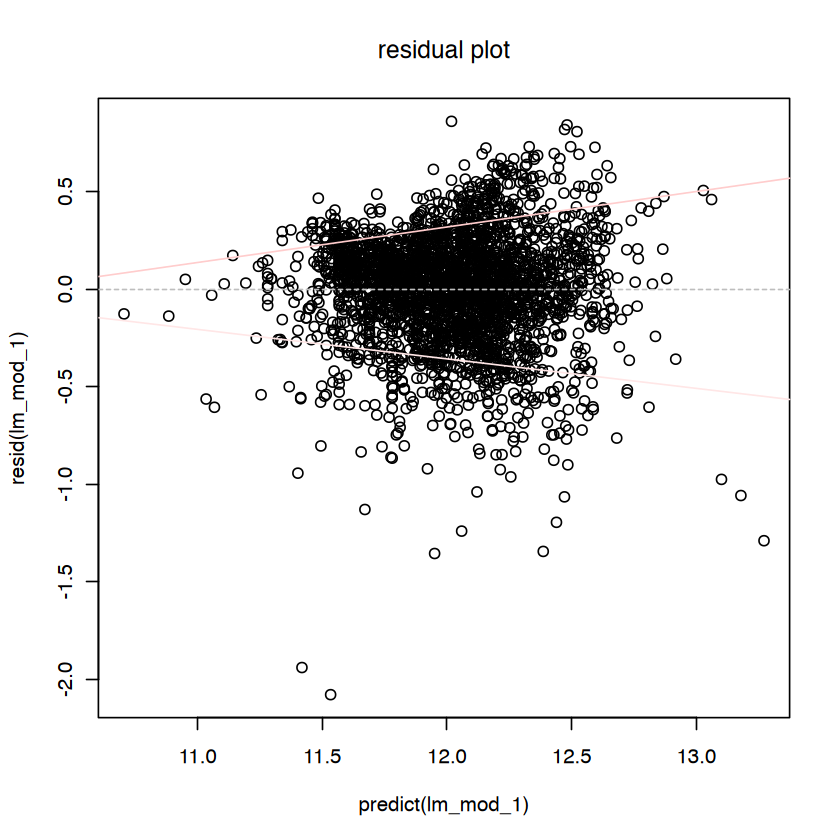

In [18]:
plot(predict(lm_mod_1),resid(lm_mod_1),main="residual plot");abline(h=0,lty=2,col="grey")
library(quantreg)
qu<-rq(resid(lm_mod_1)~predict(lm_mod_1),tau = c(0.1, 0.9))

colors <- c("#ffe6e6", "#ffcccc", "#ff9999", "#ff6666", "#ff3333",
            "#ff0000", "#cc0000", "#b30000", "#800000", "#4d0000", "#000000")
for (j in 1:ncol(qu$coefficients)) {
    abline(coef(qu)[, j], col = colors[j])
}

Did we reduce the residual variability?

No id variables; using all as measure variables

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
log(`Gr Liv Area`),1,254.4697,254.46966823,3209.97,0
Residuals,2928,232.1166,0.07927479,NA,NA


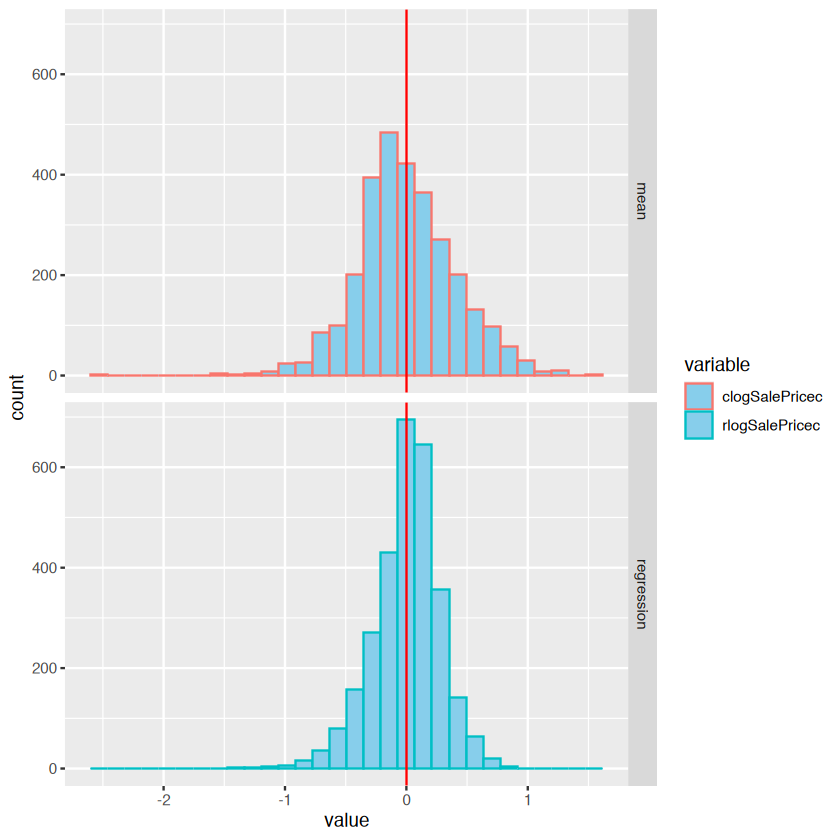

In [19]:
logSalePrice<-log(ames_raw$SalePrice)
clogSalePricec <-logSalePrice-mean(logSalePrice)
rlogSalePricec<-resid(lm_mod_1)
labs<-c("mean","regression")
names(labs)<-c("clogSalePricec","rlogSalePricec")
ggplot(melt(data.frame(clogSalePricec,rlogSalePricec)))+
  geom_histogram(fill="skyblue")+
  aes(x=value,color=variable)+geom_vline(xintercept = 0,col="red")+
  facet_grid(variable~.,labeller = labeller(variable = labs))
anova(lm_mod_1)

Looking at correlation with predictors.

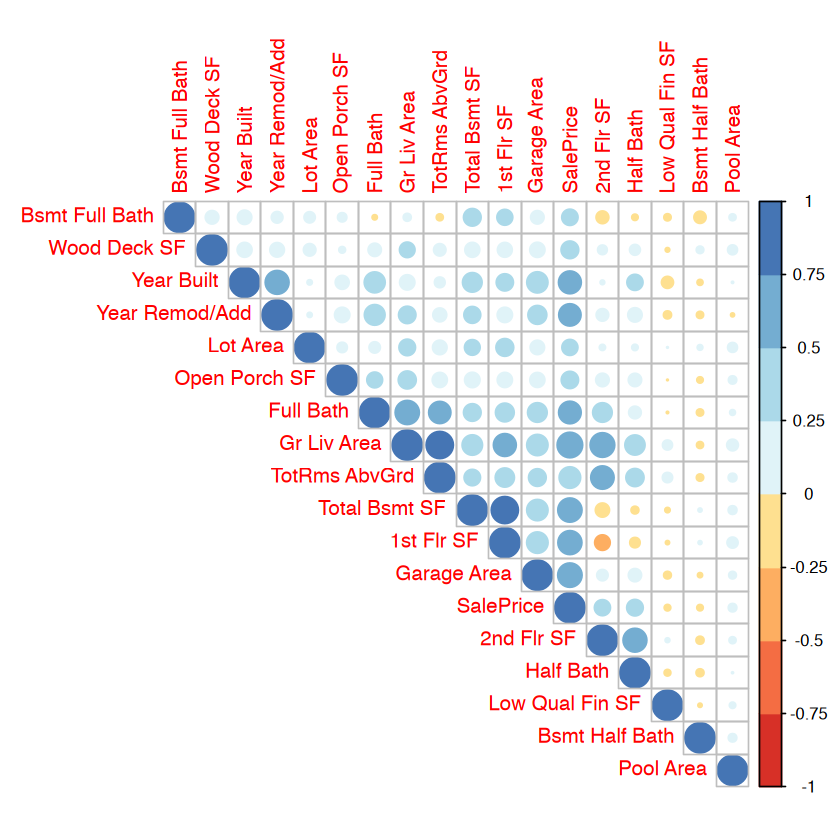

In [20]:
#`Lot Area`,`Year Built`,`Year Remod/Add`,`Total Bsmt SF`,`1st Flr SF`,`2nd Flr SF`,`Low Qual Fin SF`,`Gr Liv Area`,`Full Bath`,`Half Bath`,`Bsmt Full Bath`,`Bsmt Half Bath`,`TotRmsAbvGrd`,`Garage Area`,`Wood Deck SF`,`Open Porch SF`,`Pool Area`,`Sale Type`
M <-cor(ames_raw[,c("Lot Area","Year Built","Year Remod/Add","Total Bsmt SF","1st Flr SF","2nd Flr SF","Low Qual Fin SF","Gr Liv Area","Full Bath","Half Bath","Bsmt Full Bath","Bsmt Half Bath","TotRms AbvGrd","Garage Area","Wood Deck SF","Open Porch SF","Pool Area","SalePrice")],use="pairwise.complete.obs")
corrplot(M, type="upper", order="hclust",
         col=brewer.pal(n=8, name="RdYlBu"))

Warning message:
“Removed 6 rows containing missing values (`geom_point()`).”


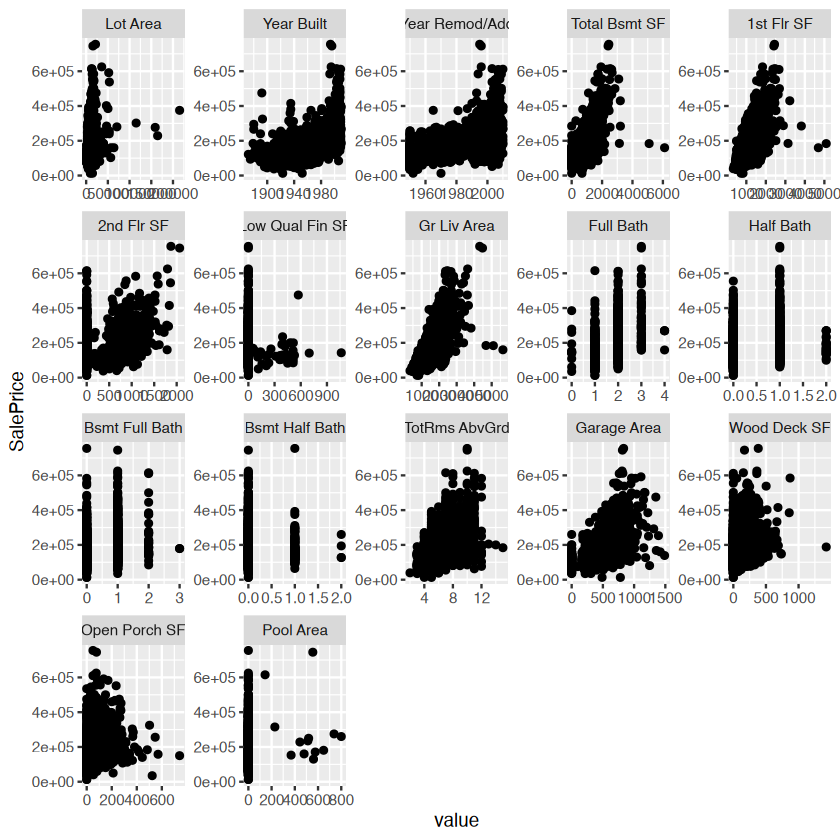

In [21]:
mames<-melt(ames_raw[,c("Lot Area","Year Built","Year Remod/Add","Total Bsmt SF","1st Flr SF","2nd Flr SF","Low Qual Fin SF","Gr Liv Area","Full Bath","Half Bath","Bsmt Full Bath","Bsmt Half Bath","TotRms AbvGrd","Garage Area","Wood Deck SF","Open Porch SF","Pool Area","SalePrice")],id.vars = "SalePrice")
ggplot(mames)+geom_point()+aes(x=value,y=SalePrice)+facet_wrap(variable~.,scales = "free")

### thinking about the `Lot Area`

When looking at lot area, its no surprise to have some relationship with the price.
But the relationship is not clear linear one.  Why?

`geom_smooth()` using formula = 'y ~ x'


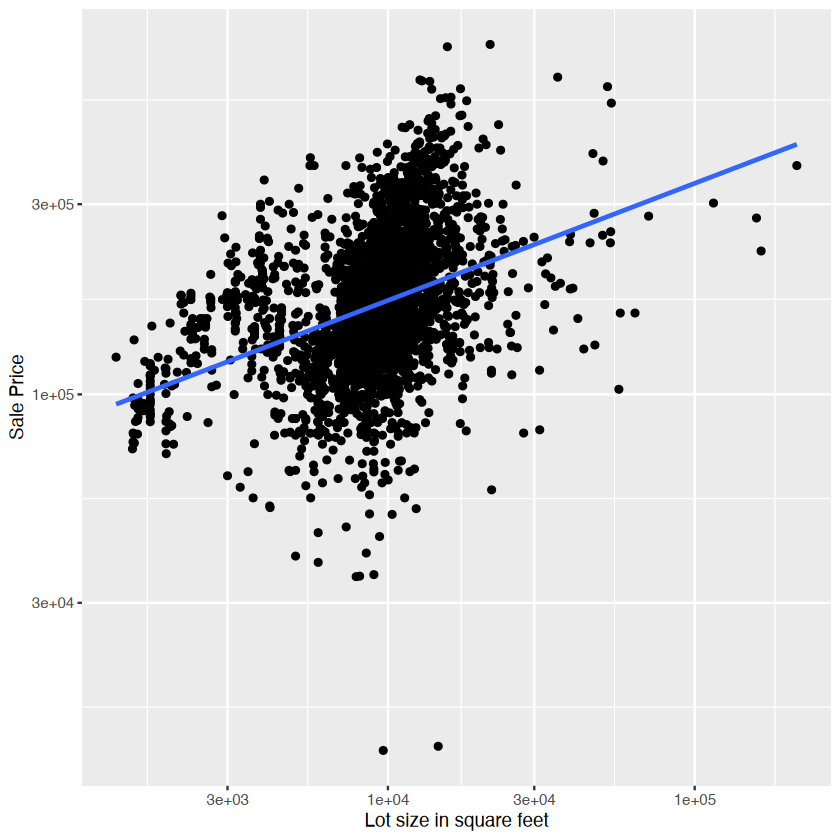

In [22]:
ggplot(ames_raw)+geom_point()+aes(x=`Lot Area`,y=SalePrice)+xlab("Lot size in square feet")+ylab("Sale Price")+geom_smooth(method="lm",se=FALSE)+scale_y_log10()+scale_x_log10()#+facet_grid(~`Bedroom AbvGr`)

If you look at this by the neighborhood it become obvious how in some places size matters more than others.

`geom_smooth()` using formula = 'y ~ x'


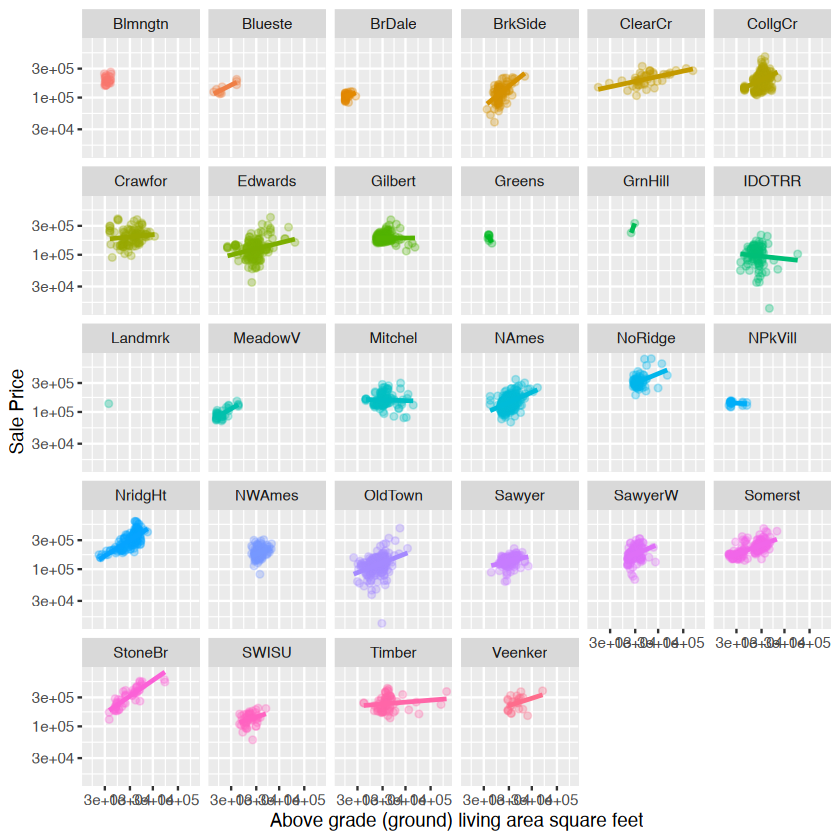

In [23]:
ggplot(ames_raw)+geom_point(alpha=0.3)+aes(x=`Lot Area`,y=SalePrice,color=factor(Neighborhood))+xlab("Above grade (ground) living area square feet")+ylab("Sale Price")+geom_smooth(method="lm",se=FALSE)+scale_y_log10()+scale_x_log10()+ theme(legend.position = "none")+facet_wrap(~Neighborhood)

### Prediction of future price based on data upto 2008

To make the project more realistic, I will split the data into before 2008 and after.
The data up to 2008 will be the training data nd after will be the testing data.

In [24]:
ames_raw_2008=ames_raw[ames_raw$`Yr Sold`<2008,]
ames_raw_2009=ames_raw[ames_raw$`Yr Sold`>=2008,]

If you look at the time trend, it seems the price is fairly stable over the years.

Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”
Warning message in regularize.values(x, y, ties, missing(ties), na.rm = na.rm):
“collapsing to unique 'x' values”


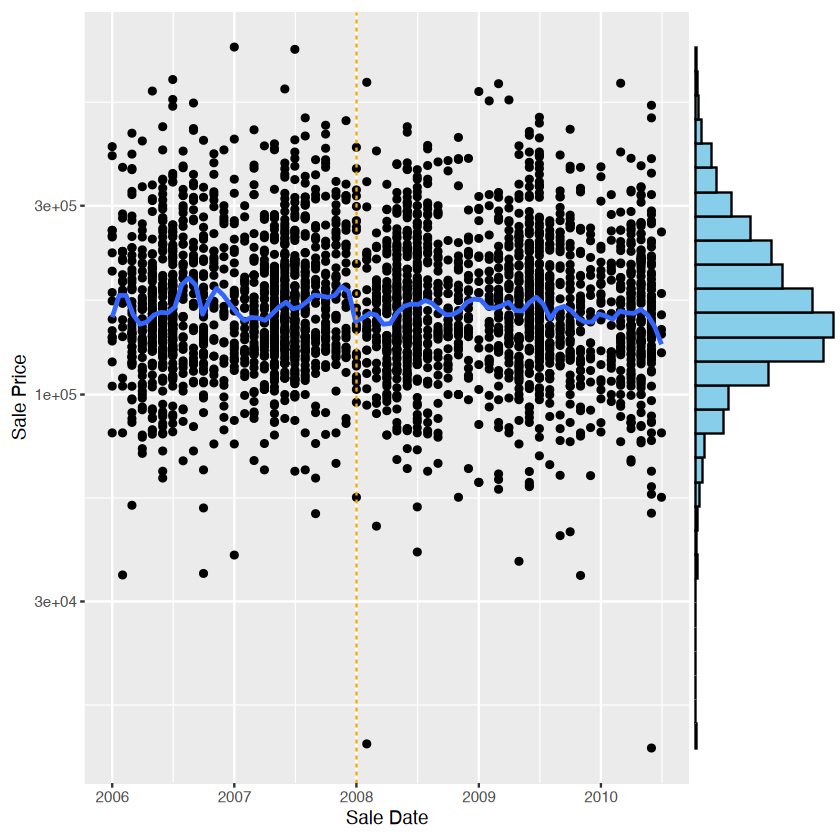

In [25]:
ames_raw$saledt <- ym(paste0(ames_raw$`Yr Sold`,"-",ames_raw$`Mo Sold`))

rolling_median <- function(formula, data, n_roll = 11, ...) {
  x <- data$x[order(data$x)]
  y <- data$y[order(data$x)]
  y <- zoo::rollmedian(y, n_roll, na.pad = TRUE)
  structure(list(x = x, y = y, f = approxfun(x, y)), class = "rollmed")
}

predict.rollmed <- function(mod, newdata, ...) {
  setNames(mod$f(newdata$x), newdata$x)
}
p=ggplot(ames_raw)+geom_point()+aes(x=saledt,y=SalePrice)+xlab("Sale Date")+ylab("Sale Price")+scale_y_log10()+geom_smooth(formula = y ~ x, method = "rolling_median",se=FALSE)+geom_vline(xintercept=ym("2008-01"),lty=2,col="orange")
p3 <- ggMarginal(p, margins = 'y', fill="skyblue", size=4,type="histogram")
p3

Fitting the null model on the training data

In [26]:
lmfit_null_2008     <- lm(SalePrice~1,ames_raw_2008)
lmfit_null_log_2008 <- lm(log(SalePrice)~1,ames_raw_2008)

Comparing the MSE

In [27]:
sqrt(mean((ames_raw_2009$SalePrice-predict(lmfit_null,newdata=ames_raw_2009))^2))
sqrt(mean((ames_raw_2009$SalePrice-exp(predict(lmfit_null_log,newdata=ames_raw_2009)))^2))

[1] 77587.03

[1] 78531.29

Comparing the business loss

In [28]:
allres_2009=ames_raw_2009$SalePrice-predict(lmfit_null,newdata=ames_raw_2009)
abs(sum(allres_2009[allres_2009<0]))+sum(0.1*(coef(lmfit_null_2008)+allres_2009[allres_2009>0]))

allreslog_2009<-(ames_raw_2009$SalePrice-exp(predict(lmfit_null_log,newdata=ames_raw_2009)))
abs(sum(allreslog_2009[allreslog_2009<0]))+sum(0.1*(exp(coef(lmfit_null_log_2008))+allreslog_2009[allreslog_2009>0]))

[1] 63806382

[1] 52684502

### In class activity

Use data of `ames_raw` up to 2008 predict the housing price for the later years.

In [29]:
ames_raw_2008=ames_raw[ames_raw$`Yr Sold`<2008,]
ames_raw_2009=ames_raw[ames_raw$`Yr Sold`>=2008,]

Use the following loss function calculator.

In [30]:
calc_loss<-function(prediction,actual){
  difpred <- actual-prediction
  RMSE <-sqrt(mean(difpred^2))
  operation_loss<-abs(sum(difpred[difpred<0]))+sum(0.1*actual[difpred>0])
  return(
    list(RMSE,operation_loss
         )
  )
}

Here are few rules:
- You are not allowed to use the test data.
- You cannot use automatic variable selection.
- You need to explain why you added each variable.

In [31]:
lmfit_2008<- # ["your model here"] # use ames_raw_2008

ERROR: Error in parse(text = x, srcfile = src): <text>:2:0: unexpected end of input
1: lmfit_2008<- # ["your model here"] # use ames_raw_2008
   ^


When you decide on your model use the following to come up with your test loss.

In [ ]:
pred_2009<-exp(predict(lmfit_2008,newdata=ames_raw_2009))
calc_loss(pred_2009,ames_raw_2009$SalePrice)

Try to answer the following additional questions.

- Does your model indicate a good fit?  If not where is the fit off?


Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

- Should you include all the predictors? Why?


Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

- What interaction makes sense?  Does your model indicate signs of interaction?


Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

- Is there evidence of non-linear association between any of the predictors and the response? To answer this question, for each predictor, fit a model with polynomial terms up to 3rd order.


Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

- What are the top 5 houses that are most over priced based on your model?

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

- What are the top 5 most good deal based on your model?

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

## Problem Set

### [Problems] Linear Regression Problems

8. This question involves the use of simple linear regression on the `Auto` data set.
(a) Use the lm() function to perform a simple linear regression with mpg as the response and horsepower as the predictor. Use the summary() function to print the results.

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


Comment on the output.
For example:
i. Is there a relationship between the predictor and the response?

ii. How strong is the relationship between the predictor and the response?

iii. Is the relationship between the predictor and the response positive or negative?

iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95% confidence and prediction intervals?

(b) Plot the response and the predictor. Use the `abline()` function to display the least squares regression line.


Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(c) Use the `plot()` function to produce diagnostic plots of the least squares regression fit. Comment on any problems you see with the fit.

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


9. This question involves the use of multiple linear regression on the `Auto` data set.

(a) Produce a scatterplot matrix which includes all of the variables in the data set.

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(b) Compute the matrix of correlations between the variables using
the function cor(). You will need to exclude the name variable,
cor() which is qualitative.

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(c) Use the lm() function to perform a multiple linear regression
with mpg as the response and all other variables except name as
the predictors. Use the summary() function to print the results.

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


Comment on the output. For instance:
i. Is there a relationship between the predictors and the response?
ii. Which predictors appear to have a statistically significant relationship to the response?

iii. What does the coefficient for the year variable suggest?

(d) Use the plot() function to produce diagnostic plots of the linear regression fit. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers? Does the leverage plot identify any observations with unusually high leverage?

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(e) Use the * and : symbols to fit linear regression models with interaction effects. Why did you add the interaction?  Explain using the context of the problem.  Do any interactions appear to be statistically significant?

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(f) Try a few different transformations of the variables, such as $log(X)$, $\sqrt{X}$, $X^2$. Comment on your findings.


This question should be answered using the Carseats data set.
(a) Fit a multiple regression model to predict Sales using Price, Urban, and US.

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(b) Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(c) Write out the model in equation form, being careful to handle the qualitative variables properly.

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(d) For which of the predictors can you reject the null hypothesis $H_0 :\beta_j = 0$?

Your answer:

~~~
Please write your answer in full sentences.


~~~

(e) On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(f) How well do the models in (a) and (e) fit the data?


Your answer:

~~~
Please write your answer in full sentences.


~~~

(g) Using the model from (e), obtain 95% confidence intervals for the coefficient(s).

Your code:

In [ ]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(h) Is there evidence of outliers or high leverage observations in the model from (e)?


Your answer:

~~~
Please write your answer in full sentences.


~~~

## Additional Material

### K-nn regression

You can do KNN regression using FNN package.
Read more about it here:
https://daviddalpiaz.github.io/r4sl/knn-reg.html

In [ ]:
library(FNN)
knn.reg(train = ?, test = ?, y = ?, k = ?)

- train: the predictors of the training data
- test: the predictor values,  x, at which we would like to make predictions
- y: the response for the training data
- k: the number of neighbors to consider

### [Advanced] Predictive Modeling Platforms in R

There are few platforms in R that does predictive modeling.
These platforms are wrappers around other packages that makes it easy to do routine tasks.

- mlr3 (https://mlr3book.mlr-org.com)
- tidymodels (https://www.tidymodels.org/)
- caret (https://topepo.github.io/caret/)
- h2o (https://docs.h2o.ai/h2o/latest-stable/h2o-r/docs/index.html)

In [ ]:
# split the data
index <- sample(1:nrow(ames_raw), 0.7*nrow(ames_raw))
vars <- c("SalePrice","Lot Area","Gr Liv Area","Full Bath")
train <- ames_raw[ index, vars]
test  <- ames_raw[-index, vars]
colnames(train) <- make.names(colnames(train))
colnames(test)  <- make.names(colnames(test))

# mlr3 TaskRegr
train$SalePrice <- log(train$SalePrice)

#### Prediction using mlr3

MLR3 is a useful ML platform on R.
You can learn about it here:
https://mlr3book.mlr-org.com
There is MLR and MLR3.  It's better to use 3 since MLR is no longer actively developed.

In [ ]:
# load packages and data
library(mlr3)
library(mlr3learners)

# fit a model

task <- as_task_regr(train, target ="SalePrice",id = "ames_raw")

# TaskRegr$new(id = "ames_raw", backend = train, target ="SalePrice")
learner <- lrn("regr.lm", predict_type = "response")
learner$train(task)
prediction=predict(learner,newdata=test)

#### Prediction using [tidymodels](https://www.tidymodels.org/)

Tidymodels is another one of the tidy family that is similar to mlr3.
https://www.tidymodels.org/

In [ ]:
# load packages and data
library(tidymodels)
library(dotwhisker)
# fit a model
rec <- recipe(SalePrice ~ ., data = train)

clf <- linear_reg()

wflow <- workflow() %>%
         add_recipe(rec) %>%
         add_model(clf)

lm_fit <- wflow %>% fit(data = train)
prediction=predict(lm_fit,new_data=test)
tidy(lm_fit) %>%
  dwplot(dot_args = list(size = 2, color = "black"),
         whisker_args = list(color = "black"),
         vline = geom_vline(xintercept = 0, colour = "grey50", linetype = 2))

#### Prediction using caret

In [ ]:
# load packages and data
library(caret)

# fit a model
ctrl <- trainControl(method = "none")
lm_model <- train(SalePrice ~ ., data = train, method = "lm", trControl = ctrl)

prediction=predict(lm_model,newdata = test)

#### Prediction using h2o

H2O is a cross platform library that is popular in the predictive modeling space.  They work well out of box and can be called from any platform independent of the language used.  Making it work on R could sometimes be a headache.  So try using H2O but if you cannot make it work, I recommend you leave this section alone.


If you are on Mac you will need to install Java (http://www.java.com ).

In [ ]:
install.packages("h2o")
# load packages and data
library(h2o)
packageVersion("h2o")

##### Starting H2O

To use H2O you need to instantiate it.

In [ ]:
# nthreads specifies number of threads. -1 means use all the CPU cores.
# max_mem_size specifies the maximum amount of RAM to use.
localH2O <- h2o.init(nthreads = -1, max_mem_size="4g")

You can access H2O instance using the web UI FLOW by typing
 http://localhost:54321
 in your browser.

##### Serving the data to H2O

Since H2O is not in R, you need to tell it to use your data.

In [ ]:
train_hf <- as.h2o(train)
test_hf <- as.h2o(test)

##### Fitting GLM

In [ ]:
gaussian.fit = h2o.glm(y = "SalePrice",                               #response variable
                       x = c("SalePrice","Lot.Area","Gr.Liv.Area","Full.Bath"),  #predictor variables
                      training_frame = train_hf,                  #data
                      family = "gaussian",lambda = 0)           #specify the dist. of y and penalty parameter: lambda
gaussian.fit

prediction=predict(gaussian.fit,newdata = test_hf)
h2o.exportFile(prediction, "/tmp/pred.csv", force = TRUE) #export prediction result as a file

##### Saving and loading the model

In [ ]:
# save the model
model_path <- h2o.saveModel(object=gaussian.fit, path=getwd(), force=TRUE)
print(model_path)

# load the model
saved_model <- h2o.loadModel(model_path)  #extract the saved model
saved_model

##### Shut down H2O

In [ ]:
h2o.shutdown(prompt =F)

## Advanced Content

### Best Linear Unbiased Estimator

#### Euler and motion of planets

The idea of regression started with Euler(1949) when he was studying the motion of planets.  He wanted to predict the location of Jupiter.  Euler had 75 observations for a linear model with seven unknown constants; equivalently, he had 75 equations and seven unknowns.

Let's translate this into a more familiar notation that we are used to.  We will let
\begin{eqnarray*}
y_i=\varphi_i\verb|, |\boldsymbol{\beta}=\left(\begin{array}{c}
\beta_1\\
\beta_2\\
\vdots\\
\beta_p
\end{array}\right)
 \verb|, and | \mathbf{X}_i=\left(\begin{array}{c}
x_{i1} \\
x_{i2} \\
\vdots\\
x_{ip} \\
\end{array}\right)
\end{eqnarray*}

Then, we can write the equation as
\begin{eqnarray*}
y_i=\mathbf{X}_i^T\boldsymbol{\beta}=x_{i1}\beta_1+x_{i2}\beta_2+\cdots+x_{ip}\beta_p \verb| for |i=1,\cdots,n=75
\end{eqnarray*}

There are a few assumptions that went into the model

- $y_i$ is linear in $\beta$
- But it can be non-linear in the variables.
- The model is known to be correct a priori

From calculus, we know that when we have seven unknowns, we need seven equations to estimate those unknowns.  Since Euler had 75 equations, he needed a way to convert those 75 equations into seven equations.  The simplest thing to do is randomly choose seven equations out of 75 equations and solve for the unknowns using only the selected equations.  But Laplace came up with a better idea: to combine 75 equations so that you get seven equations as weighted linear combinations of the 75 equations.  That is, each equation is

\begin{eqnarray*}
\sum^n_{i=1}w_iy_i=\sum^n_{i=1}w_i\mathbf{X}_i^T\boldsymbol{\beta}
\end{eqnarray*}

If we combine all the weights into a matrix
\begin{eqnarray*}
\mathbf{W}=\left(
\begin{array}{cccc}
w_{11}&w_{12}&\cdots &w_{1p} \\
\vdots&\vdots&\ddots&\vdots\\
w_{n1}&w_{n2}&\cdots &w_{np} \\
\end{array}
\right)
\end{eqnarray*}

Then 75 equations $Y_{75\times 1}=\mathbf{X}_{75\times 7}\boldsymbol{\beta}_{7\times1}$ can be expressed as
\begin{eqnarray*}
(\mathbf{W}^TY)_{7\times 1}=(\mathbf{W}^T\mathbf{X})_{7\times 7}\boldsymbol{\beta} \rightarrow (\mathbf{W}^T\mathbf{X})^{-1}(\mathbf{W}^TY)_{7\times 1}=\hat{\hspace{0pt}\boldsymbol{\beta}}
\end{eqnarray*}

This makes us ask a new question: what $\mathbf{W}$ do we want to get the optimal estimate of $\boldsymbol{\beta}$?

#### Special case for when $p=1$
Let us start with a case where we only have one unknown variable.  we have
\begin{eqnarray*}
\mathbf{X}=\left[
\begin{array}{c}
x_{1} \\
\vdots\\
x_{n} \\
\end{array}
\right]\verb|, |
Y=\left[
\begin{array}{c}
y_{1} \\
\vdots\\
y_{n} \\
\end{array}
\right]\verb|, and |
\mathbf{W}=\left[
\begin{array}{c}
w_{1} \\
\vdots\\
w_{n} \\
\end{array}
\right]
\end{eqnarray*}

In this case, we can combine $n$ equations as
\begin{eqnarray*}
\sum^n_{i=1}w_iy_i=\sum^n_{i=1}w_i\mathbf{X}_i^T\boldsymbol{\beta}
\end{eqnarray*}
solving for $\boldsymbol{\beta}$ gives us
\begin{eqnarray*}
\hat{\hspace{0pt}\boldsymbol{\beta}}&=&\frac{\sum_i^n w_iy_i}{\sum_i^n w_i x_i} \\
					 &=&\frac{\langle \mathbf{W}, Y\rangle}{\langle \mathbf{W},  \mathbf{X}\rangle}
\end{eqnarray*}

What is the optimal $\mathbf{W}$ in this case?  Let's formulate this problem in a statistical framework.

We need to make a few assumptions
As already stated, we will have the following assumptions.

- There is true model for $\boldsymbol{\beta}_{true}$ $Y=\mathbf{X}_i\boldsymbol{\beta}_{true}+\epsilon_i$
- $E(\epsilon_i)=0$, $Var(\epsilon_i)=\sigma^2$, and $Cov(\epsilon_i,\epsilon_j)=0$ for all $i,j=1,\cdots, n$
- $\mathbf{X}_i$'s are fixed by design

We will start with the estimating equation
\begin{eqnarray*}
\hat{\hspace{0pt}\boldsymbol{\beta}}&=&\frac{\langle \mathbf{W}, \mathbf{X}\boldsymbol{\beta}_{true}+\epsilon \rangle}{\langle \mathbf{W},  \mathbf{X}\rangle}\\
&=&\boldsymbol{\beta}_{true}+\frac{\langle \mathbf{W}, \epsilon \rangle}{\langle \mathbf{W},  \mathbf{X}\rangle}\\
\end{eqnarray*}

The Frequentist view of statistics is relevant for this case because when we fit a model, we want to use the procedure repeatedly.  Thus, we can do hypothetical repeated sampling. For each repetition, we get $\epsilon_i$'s, from which we get $Y$, which gives us different $\hat{\hspace{0pt}\boldsymbol{\beta}}$.
Then $E(\hat{\hspace{0pt}\boldsymbol{\beta}})$ is the long run average under repetition.  $Var(\hat{\hspace{0pt}\boldsymbol{\beta}})$ is long run variance under repetition.


From the assumptions, we know
\begin{eqnarray*}
E\left(\langle \mathbf{W}, \epsilon\rangle\right)&=&\sum^n_{i=1}E\left(w_i \epsilon_i\right)\\
&=&\sum^n_{i=1}w_i E(\epsilon_i)\\
&=&0
\end{eqnarray*}
and
\begin{eqnarray*}
Var\left(\langle \mathbf{W}, \epsilon\rangle \right)&=&Var\left(\sum^n_{i=1}w_i \epsilon_i \right)\\
&=&\sum^n_{i=1}Var(w_i \epsilon_i)\\
&=&\sum^n_{i=1}w_i^2Var(\epsilon_i)\\
&=&\lVert w \rVert^2\sigma^2\\
\end{eqnarray*}

Therefore
\begin{eqnarray*}
E\left( \hat{\hspace{0pt}\boldsymbol{\beta}} \right) &=& E\left(\boldsymbol{\beta}_{true}+ \frac{\langle \mathbf{W} \ \epsilon\rangle }{\langle \mathbf{W}\ \mathbf{X}\rangle} \right)\\
&=&\boldsymbol{\beta}_{true}\\
\end{eqnarray*}
\begin{eqnarray*}
Var\left(\hat{\hspace{0pt}\boldsymbol{\beta}}\right) &=& Var\left(\boldsymbol{\beta}_{true}+ \frac{\langle \mathbf{W} \ \epsilon\rangle }{\langle \mathbf{W}\   \mathbf{X}\rangle }\right)\\
&=&Var\left(\frac{\langle \mathbf{W} \ \epsilon\rangle }{\langle \mathbf{W}\   \mathbf{X}\rangle }\right)\\
&=&\frac{\lVert \mathbf{W} \rVert^2\sigma^2}{|\langle \mathbf{W}\  \mathbf{X} \rangle |^2}\\
&=&\frac{\lVert \mathbf{W} \rVert^2\sigma^2}{(\lVert \mathbf{W}\lVert \lVert \mathbf{X} \lVert cos\theta)^2}\\
&=&\frac{\sigma^2}{\lVert \mathbf{X} \rVert^2 cos^2\theta}
\end{eqnarray*}
Thus we see in general $Var(\hat{\hspace{0pt}\boldsymbol{\beta}})$ is minimized when $cos^2\theta=1$, which is when $\theta=0$, hence $\mathbf{W}\propto \mathbf{X}$.
Indicating that when $\mathbf{W} = c\mathbf{X}_i$ for some constant $c$, $\hat{\hspace{0pt}\boldsymbol{\beta}}$ will have minimum variance.

In [ ]:
knitr::include_graphics("./Images/WWXangle.png")

Alternatively we can start from objective function $R(\boldsymbol{\beta})=\sum^{n}_{i=1}{(y_i-\mathbf{X}_i\boldsymbol{\beta})^2}$ and try to find $\boldsymbol{\beta}$ that minimizes $R(\boldsymbol{\beta})$.
\begin{eqnarray*}
R(\boldsymbol{\beta})'&=&-2\sum^{n}_{i=1}{(y_i-x_i\boldsymbol{\beta})x_i}=0\\
&\Rightarrow&\sum^{n}_{i=1}{(x_i^2\boldsymbol{\beta})}=\sum^{n}_{i=1}{(y_ix_i)}\\
&\Rightarrow&\hat{\hspace{0pt}\boldsymbol{\beta}}_{LS}=\frac{\sum^{n}_{i=1}{(y_ix_i)}}{\sum^{n}_{i=1}{(x_i^2)}}\\
\end{eqnarray*}
The resulting $\boldsymbol{\beta}_{LS}$ is the least squares estimate of $\boldsymbol{\beta}$.  Which we see is a particular case of the general estimating equation when $w_i=\mathbf{X}_i$.  Because of this result, the Least Squared Estimate is called the best unbiased linear estimator (BLUE).

#### For General $p$
We can do the same for more general $p$, for
\begin{eqnarray*}
\mathbf{X}=\left[
\begin{array}{cccc}
x_{11}&x_{12}&\cdots &x_{1p} \\
\vdots&\vdots&\ddots&\vdots\\
x_{n1}&x_{n2}&\cdots &x_{np} \\
\end{array}
\right]\verb|, |
Y=\left[
\begin{array}{c}
y_{1} \\
\vdots\\
y_{n} \\
\end{array}
\right]\verb|, |
\epsilon=\left[
\begin{array}{c}
\epsilon_{1} \\
\vdots\\
\epsilon_{n} \\
\end{array}
\right] \verb|, and |
\boldsymbol{\beta}=\left[
\begin{array}{c}
\beta_{1} \\
\vdots\\
\beta_{p} \\
\end{array}
\right]
\end{eqnarray*}

We still have the same assumption

- There is true model for $\boldsymbol{\beta}_{true}$, $Y=\mathbf{X}\boldsymbol{\beta}_{true}+\epsilon$
- $E(\epsilon)=0$, $Var(\epsilon)=\sigma^2I$
- $X$ is fixed by design

Again define objective function as $R(\boldsymbol{\beta})=\sum^{n}_{i=1}{\lVert Y-\mathbf{X}\boldsymbol{\beta}\rVert^2}$, least square estimate of $\boldsymbol{\beta}$, $\boldsymbol{\beta}_{LS}$ is the one that minimizes this loss function.  We can derive $\boldsymbol{\beta}_{LS}$ via taking the derivative of $R(\boldsymbol{\beta})$ with respect to $\boldsymbol{\beta}$ and setting that equal to zero.  Hence

\begin{eqnarray*}
R(\boldsymbol{\beta})'&=&-2\mathbf{X}^{T}{(Y-\mathbf{X}\boldsymbol{\beta})}\\
&\Rightarrow&-2(\mathbf{X}^{T}Y-\mathbf{X}^{T}\mathbf{X}\boldsymbol{\beta})=0\\
&\Rightarrow&\mathbf{X}^{T}\mathbf{X}\boldsymbol{\beta}=\mathbf{X}^{T}Y\\
&\Rightarrow&\hat{\hspace{0pt}\boldsymbol{\beta}}_{LS}=(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}Y\\
\end{eqnarray*}
So, our estimated value of $Y$ in the space spanned by $\mathbf{X}$ using the least squares estimate of the $\boldsymbol{\beta}$ can be written as
\begin{eqnarray*}
\hat{\hspace{0pt}Y}=\mathbf{X}\hat{\hspace{0pt}\boldsymbol{\beta}}_{LS} = \mathbf{X}(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}Y\\
\end{eqnarray*}

Because $\hat{\hspace{0pt}Y}$ lives in space spanned by $X$ since $X\boldsymbol{\beta}$ is linear combination of $\mathbf{X}$, $\mathbf{X}(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}$ can be thought of as projection matrix that projects $Y$ onto space spanned by $\mathbf{X}$.  This matrix is often denoted by capital letter $H$ and called the hat matrix $H=\mathbf{X}(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}$.  The hat matrix is a symmetric matrix that implies $H^T=H$ and $H^2=H$.

In [ ]:
knitr::include_graphics("./Images/LSvector.png")

Under our assumption, least square estimates have the following property.
\begin{eqnarray*}
E(\hat{\hspace{0pt}\boldsymbol{\beta}}_{LS})&=&E((\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}Y)\\
&=&E((\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}(\mathbf{X}\boldsymbol{\beta}_{true}+\epsilon))\\
&=&\boldsymbol{\beta}_{true}\\
\end{eqnarray*}
\begin{eqnarray*}
Var(\hat{\hspace{0pt}\boldsymbol{\beta}}_{LS})&=&Var((\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}Y)\\
&=&Var((\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}(\mathbf{X}\boldsymbol{\beta}_{true}+\epsilon))\\
&=&Var((\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\epsilon)\\
&=&(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}Var(\epsilon)((\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T})^T\\
&=&(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\sigma^2I((\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T})^T\\
&=&\sigma^2(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{X}(\mathbf{X}^{T}\mathbf{X})^{-1}\\
&=&\sigma^2(\mathbf{X}^{T}\mathbf{X})^{-1}\\
\end{eqnarray*}

Going back to the general estimating equation,
\begin{eqnarray*}
\hat{\hspace{0pt}\boldsymbol{\beta}}=(\mathbf{W}^T\mathbf{X})^{-1}(\mathbf{W}^TY)&=&(\mathbf{W}^T\mathbf{X})^{-1}(\mathbf{W}^T\mathbf{X}\boldsymbol{\beta}_{true}+\epsilon)\\
&=&\boldsymbol{\beta}_{true}+(\mathbf{W}^T\mathbf{X})^{-1}\mathbf{W}^T\epsilon
\end{eqnarray*}
\begin{eqnarray*}
E(\hat{\hspace{0pt}\boldsymbol{\beta}})&=&E(\boldsymbol{\beta}_{true}+(\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T\epsilon)\\
&=&E(\boldsymbol{\beta}_{true})+E((\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T\epsilon)\\
&=&\boldsymbol{\beta}_{true}+(\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T E(\epsilon)\\
&=&\boldsymbol{\beta}_{true}\\
\end{eqnarray*}
\begin{eqnarray*}
Var(\hat{\hspace{0pt}\boldsymbol{\beta}})&=&Var(\boldsymbol{\beta}_{true}+(\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T\epsilon)\\
&=&Var((\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T\epsilon)\\
&=&(\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T Var(\epsilon)((\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T)^T\\
&=&(\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T \sigma^2I((\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T)^T\\
&=&\sigma^2(\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T ((\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T)^T\\
\end{eqnarray*}

If we denote $(\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T$ as $A$ then
\begin{eqnarray*}
Var(\hat{\hspace{0pt}\boldsymbol{\beta}})&=&\sigma^2\lVert A\rVert^2\\
\end{eqnarray*}

We will use the following consequence of Cauchy-Schwarz inequality due to the symmetry of the hat matrix
\begin{eqnarray*}
\lVert Y\rVert^2 \geq \lVert \hat{\hspace{0pt}Y}\rVert^2 \Rightarrow Y^TY \geq (HY)^T(HY)=Y^THY
\end{eqnarray*}
which is true for all $Y$.

Hence
\begin{eqnarray*}
A^TA&\geq&A^TH^THA \\
&=&(\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T \mathbf{X}(\mathbf{X}^T \mathbf{X})^{-1}\mathbf{X}^T (\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T)^T\\
&=&(\mathbf{X}^T \mathbf{X})^{-1}
\end{eqnarray*}

Therefore we have $Var(\hat{\hspace{0pt}\boldsymbol{\beta}})\geq \sigma^2(\mathbf{X}^T \mathbf{X})^{-1}=Var(\hat{\hspace{0pt}\boldsymbol{\beta}}_{LS})$, telling us once again that the least squares archive the minimum variance of the general estimator estimate, proving the BLUE property of least squares estimate.

### Model Complexity
Up to here, we assumed we knew that the true model is a linear combination of $\mathbf{X}$, but we know that is not true in general.  However, that still does not invalidate the use of least squares estimate, as Box's quote has it, ``All models are wrong, but some are useful''.  So, let us look at how our model will behave under more general assumptions.

We will assume $Y=f(\mathbf{X})+\epsilon$ where $f$ is some unknown function, and $E[\epsilon]=0$ and $Var[\epsilon]=\sigma^2I$.  Also we will assume $\mathbf{X}_1,\mathbf{X}_2,\cdots,\mathbf{X}_p$ are orthonormal.  We will not assume a linear model for $f$, but we will try to estimate $Y$ using the method of least squares. Thus $\hat{\hspace{0pt}Y}=H(f+\epsilon)=\hat{\hspace{0pt}f}+\hat{\hspace{0pt}\epsilon}$.  $\hat{\hspace{0pt}f}=\mathbf{X}\boldsymbol{\beta}_{best}$ where $\boldsymbol{\beta}_{best}$ is the best we can do knowing our true model $f$ is not linear. Also $\hat{\hspace{0pt}\epsilon}=\mathbf{X}\delta$ where $\delta=[\delta_1,\delta_2,\cdots,\delta_p]^T$ and $E[\delta_i]=0$, $Var(\delta_i)=\sigma^2$ hence $E(\epsilon)=0$ and $E\left[\lVert\epsilon\rVert^2\right]=E\left[ \lVert \mathbf{X}_1\rVert^2\delta_1^2+\cdots+\lVert\mathbf{X}_p\rVert^2\delta_p^2\right]=p\sigma2^2$ which follows since $\lVert \mathbf{X}_i\rVert^2=1$ from orthonormal assumption we made earlier.


obs      | predictor |          |          |          |  f       | randomn in train   | training   data      |randomness in test | testing   data
---------|-----------|----------|----------|----------| ---------|--------------|----------------------|-------------------|---------------------------------
1        | $x_{11}$  | $x_{12}$ | $\cdots$ | $x_{1p}$ | $f_1$    | $\epsilon_1$ | $y_1=f_1+\epsilon_1$ |$\epsilon_{1,new}$ | $y_{1,new}=f_1+\epsilon_{1,new}$
2        | $x_{21}$  | $x_{22}$ | $\cdots$ | $x_{2p}$ | $f_2$    | $\epsilon_2$ | $y_2=f_2+\epsilon_2$ |$\epsilon_{2,new}$ | $y_{2,new}=f_2+\epsilon_{2,new}$
$\vdots$ | $\vdots$  | $\vdots$ | $\ddots$ | $\vdots$ | $\vdots$ | $\vdots$     | $\vdots$             |$\vdots$           | $\vdots$
n        | $x_{n1}$  | $x_{n2}$ | $\cdots$ | $x_{np}$ | $f_n$    | $\epsilon_n$ | $y_n=f_n+\epsilon_n$ |$\epsilon_{n,new}$ | $y_{n,new}=f_n+\epsilon_{n,new}$
---------|-----------|----------|----------|----------| ---------|--------------|----------------------|-------------------|---------------------------------
 &nbsp;  | $\mathbf{X}_{1}$   | $\mathbf{X}_{2}$  | $\cdots$ | $\mathbf{X}_{p}$  | $f$      | $\epsilon$   | $Y=f+\epsilon$       |$\epsilon_{new}$  | $Y_{new}=f+\epsilon_{new}$


Under this setting, let's look at the training and testing errors and their behavior.
- Training Error
\begin{eqnarray*}
E\left[\lVert Y-\hat{\hspace{0pt}Y}\rVert^2\right]&=&E\left[\lVert (f+\epsilon)-(\hat{\hspace{0pt}f}+\hat{\hspace{0pt}\epsilon})\rVert^2\right]\\
&=&E\left[\lVert (f-\hat{\hspace{0pt}f})+(\epsilon-\hat{\hspace{0pt}\epsilon})\rVert^2\right]\\
&=&E\left[\lVert (f-\hat{\hspace{0pt}f})\rVert^2+\lVert(\epsilon-\hat{\hspace{0pt}\epsilon})\rVert^2-2\langle(f-\hat{\hspace{0pt}f})\ (\epsilon-\hat{\hspace{0pt}\epsilon})\rangle\right]\\
&=&\lVert (f-\hat{\hspace{0pt}f})\rVert^2+E\left[\lVert\epsilon\rVert^2-\lVert\hat{\hspace{0pt}\epsilon}\rVert^2\right]\\
&=&\lVert (f-\hat{\hspace{0pt}f})\rVert^2+n\sigma^2-p\sigma^2\\
\end{eqnarray*}

In [ ]:
knitr::include_graphics("./Images/trainingErrorDecomposed.png")

Which follows from the fact that $\hat{\hspace{0pt}\epsilon}$ is the projection of $\epsilon$,

In [ ]:
knitr::include_graphics("./Images/epsilon.png")

\begin{eqnarray*}
E\left[\lVert\epsilon-\hat{\hspace{0pt}\epsilon}\rVert^2\right]&=&E\left[\lVert\epsilon\rVert^2\right]+E\left[\lVert\hat{\hspace{0pt}\epsilon}\rVert^2\right]
-2E\left[\langle \epsilon\ \hat{\hspace{0pt}\epsilon}\rangle\right]\\
&=&n\sigma^2+p\sigma^2-2p\sigma^2\\
&=&n\sigma^2-p\sigma^2\\
\end{eqnarray*}
Thus we get the Pythagoras Theorem $\lVert\epsilon-\hat{\hspace{0pt}\epsilon}\rVert^2=\lVert \epsilon\rVert^2-\lVert\hat{\hspace{0pt}\epsilon}\rVert^2$.

- Testing Error
\begin{eqnarray*}
E\left[\lVert Y_{new}-\hat{\hspace{0pt}Y}\rVert^2\right]&=&E\left[\lVert (f+\epsilon_{new})-(\hat{\hspace{0pt}f}+\hat{\hspace{0pt}\epsilon})\rVert^2\right]\\
&=&E\left[\lVert (f-\hat{\hspace{0pt}f})+(\epsilon_{new}-\hat{\hspace{0pt}\epsilon})\rVert^2\right]\\
&=&E\left[\lVert (f-\hat{\hspace{0pt}f})\rVert^2+\lVert(\epsilon_{new}-\hat{\hspace{0pt}\epsilon})\rVert^2-2\langle(f-\hat{\hspace{0pt}f})\ (\epsilon_{new}-\hat{\hspace{0pt}\epsilon})\rangle\right]\\
&=&\lVert (f-\hat{\hspace{0pt}f})\rVert^2+E\left[\lVert\epsilon_{new}\rVert^2+\lVert\hat{\hspace{0pt}\epsilon}\rVert^2\right]\\
&=&\lVert (f-\hat{\hspace{0pt}f})\rVert^2+n\sigma^2+p\sigma^2\\
&=&\verb|testing error| = \verb|training error| + 2p\sigma^2
\end{eqnarray*}

In [ ]:
knitr::include_graphics("./Images/testingErrorDecomposed.png")

But for testing error this is different since $\hat{\hspace{0pt}\epsilon}$ is not projection of $\epsilon_{new}$:

In [ ]:
knitr::include_graphics("./Images/epsnew.png")

\begin{eqnarray*}
E\left[\lVert\epsilon_{new}-\hat{\hspace{0pt}\epsilon}\rVert^2\right]&=&E\left[\lVert\epsilon_{new}\rVert^2\right]+E\left[\lVert\hat{\hspace{0pt}\epsilon}\rVert^2\right] -2E\left[\langle \epsilon_{new}\ \hat{\hspace{0pt}\epsilon}\rangle\right]\\
&=&n\sigma^2+p\sigma^2-0\\
&=&n\sigma^2+p\sigma^2\\
\end{eqnarray*}






- Estimation Error
\begin{eqnarray*}
E\left[\lVert \hat{\hspace{0pt}Y}-f\rVert^2\right]&=&E\left[\lVert (\hat{\hspace{0pt}f}+\hat{\hspace{0pt}\epsilon})-f\rVert^2\right]\\
&=&E\left[\lVert (f-\hat{\hspace{0pt}f})+\hat{\hspace{0pt}\epsilon}\rVert^2\right]\\
&=&E\left[\lVert (f-\hat{\hspace{0pt}f})\rVert^2+\lVert(\hat{\hspace{0pt}\epsilon})\rVert^2-2\langle(f-\hat{\hspace{0pt}f})\ \hat{\hspace{0pt}\epsilon}\rangle\right]\\
&=&\lVert (f-\hat{\hspace{0pt}f})\rVert^2+p\sigma^2\\
&=&\verb|estimation error| = \verb|training error| - n\sigma^2 + 2p\sigma^2
\end{eqnarray*}

- Error of $\boldsymbol{\beta}_{best}$
\begin{eqnarray*}
E\left[\lVert Y-\hat{\hspace{0pt}f}\rVert^2\right]&=&E\left[\lVert (f+\epsilon)-\hat{\hspace{0pt}f}\rVert^2\right]\\
&=&E\left[\lVert (f-\hat{\hspace{0pt}f})+\epsilon\rVert^2\right]\\
&=&E\left[\lVert (f-\hat{\hspace{0pt}f})\rVert^2+\lVert(\epsilon)\rVert^2-2\langle(f-\hat{\hspace{0pt}f})\ \epsilon\rangle\right]\\
&=&\lVert (f-\hat{\hspace{0pt}f})\rVert^2+n\sigma^2\\
\end{eqnarray*}
Also we see that error of $\boldsymbol{\beta}_{best}$ = training error + $p\sigma^2$.

#### Training error, estimation error, error of $\boldsymbol{\beta}_{best}$and testing error

|                                     |                                                                     |
|-------------------------------------|---------------------------------------------------------------------|
|training error                       | $\lVert (f-\hat{\hspace{0pt}f})\rVert^2+n\sigma^2-p\sigma^2$        |
|estimation error                     | $\lVert (f-\hat{\hspace{0pt}f})\rVert^2+p\sigma^2$                  |
|error of $\boldsymbol{\beta}_{best}$ | $\lVert (f-\hat{\hspace{0pt}f})\rVert^2+n\sigma^2$                  |
|testing error                        | $\lVert (f-\hat{\hspace{0pt}f})\rVert^2+n\sigma^2+p\sigma^2$.       |


Thus, we see that

|                                     |                                                                     |
|-------------------------------------|---------------------------------------------------------------------|
|when $n>2p$                           | estimation error $\leq$ training error $\leq$ error of $\boldsymbol{\beta}_{best}$ $\leq$ testing error |
|when $2p>n>p$                         | training error $\leq$ estimation error $\leq$ error of $\boldsymbol{\beta}_{best}$ $\leq$ testing error |
|when $n=p$                            | training error $\leq$ estimation error $=$ error of $\boldsymbol{\beta}_{best}$ $\leq$ testing error |
|when $n<p$                            | training error $\leq$ error of $\boldsymbol{\beta}_{best}$ $\leq$ estimation error  $\leq$ testing error |

This shows that the relative size of n to p affects the relative size of the estimation error to the other errors, but the relative size of the estimation error, error of $\boldsymbol{\beta}_{best}$, and testing error are stable.  If we increase $p$ we will have less training error because of the $-p\sigma^2$ term, which also increases the testing error by the $+p\sigma^2$ term.

When you plot the errors against p, you will see that the training error will always go down with an increase in $p$, but the testing error will go down up to some point and then increase.  This is because when you increase $p$, not only does $-p\sigma^2$ term decrease the error for training, but also, an increase in $p$ will reduce the model bias term $\lVert (f-\hat{\hspace{0pt}f})\rVert^2$.  The reduction in error by the reduction in model bias is responsible for the initial decrease in testing error.  However, at some point, the decrease in model bias gets overwhelmed by the $+p\sigma^2$ term, which is the reason testing error increases at some point.

In [ ]:
knitr::include_graphics("./Images/Overlearning.png")

#### Some thoughts on extreme cases
In extreme cases where $Y$ is pure noise, that is $f=0$.  Then $n=p$ and $\epsilon=\hat{\hspace{0pt}\epsilon}$.  Therefore, your training error will be 0, but when you test your model, then $\epsilon_{new}+\hat{\hspace{0pt}\epsilon}=\epsilon_{new}+\epsilon$ which is more error in general.
Generally speaking, you don't want to be too clever and interpret too many patterns in your error, or else you will be penalized in your test.

#### Decomposition of estimation error
For general estimator $\tilde{\hspace{0pt}\boldsymbol{\beta}}$, let $\hat{\hspace{0pt}f}=\mathbf{X}\boldsymbol{\beta}_{best}$, and let $\mu=E[\tilde{\hspace{0pt}\boldsymbol{\beta}}]$.  Then estimation error can be decomposed into model bias, estimation bias, and estimation variance.

\begin{eqnarray*}
E\lVert f-\mathbf{X}\tilde{\hspace{0pt}\boldsymbol{\beta}}\rVert^2&=&E\lVert f-\hat{\hspace{0pt}f}+\mathbf{X}\boldsymbol{\beta}_{best}-\mathbf{X}\tilde{\hspace{0pt}\boldsymbol{\beta}}\rVert^2\\
&=&\lVert f-\hat{\hspace{0pt}f}\rVert^2+E\lVert \mathbf{X}\boldsymbol{\beta}_{best}-\mathbf{X}\tilde{\hspace{0pt}\boldsymbol{\beta}}\rVert^2\\
&=&\lVert f-\hat{\hspace{0pt}f}\rVert^2+\lVert \boldsymbol{\beta}_{best}-\mu \rVert^2 +E\lVert \mu - \tilde{\hspace{0pt}\boldsymbol{\beta}}\rVert^2 \\
\end{eqnarray*}

If the $\tilde{\hspace{0pt}\boldsymbol{\beta}}=\hat{\hspace{0pt}\boldsymbol{\beta}}_{LS}$, that is $E[\hat{\hspace{0pt}\boldsymbol{\beta}}_{LS}]=\boldsymbol{\beta}_{best}$, then $\lVert \boldsymbol{\beta}_{best}-\mu \rVert^2=0$.


Model bias and estimation bias can be very ambiguous.  Suppose there are 20000 predictors, $p=20000$ and $n$, that are not quite as large as $p$.
To fit a model in such a situation, there are two ways to go about it, both of which will be discussed later under the topic of regularization.  One is to do model selection, where you leave the most significant predictors in the model and exclude the rest.  Another is to do a shrinkage estimation where you shrink most of the estimates down to zero.  Essentially, you are doing the same thing; however, model selection will increase the model bias, whereas the shrinkage method will increase the estimation bias.

### Property of General Estimator Error
(1) For a general estimator of regression coefficients, investigate the relationship between the testing (generalization, prediction) error and training error and identify the effective degrees of freedom.

obs.     | predictor 1| predictor 2| $\cdots$  |predictor p  | $f$  | randomness in training   | training data | randomness in testing  | testing data
---------|-----------|----------|----------|----------|---------|--------------|----------------------|-------------------|---------------------------------
1        | $x_{11}$ | $x_{12}$ | $\cdots$ | $x_{1p}$ |$f_1$     | $\epsilon_1$ | $y_1=f_1+\epsilon_1$ |$\epsilon_{1,new}$   | $y_{1,new}=f_1+\epsilon_{1,new}$
2        | $x_{21}$ | $x_{22}$ | $\cdots$ | $x_{2p}$ |$f_2$     | $\epsilon_2$ | $y_2=f_2+\epsilon_2$ |$\epsilon_{2,new}$   | $y_{2,new}=f_2+\epsilon_{2,new}$
$\vdots$ | $\vdots$ | $\vdots$ | $\ddots$ | $\vdots$ |$\vdots$  | $\vdots$     | $\vdots$             |$\vdots$             | $\vdots$
n        | $x_{n1}$ | $x_{n2}$ | $\cdots$ | $x_{np}$ |$f_n$     | $\epsilon_n$ | $y_n=f_n+\epsilon_n$ |$\epsilon_{n,new}$   | $y_{n,new}=f_n+\epsilon_{n,new}$
&nbsp;   | $\mathbf{X}_{1}$  | $\mathbf{X}_{2}$  | $\cdots$ | $\mathbf{X}_{p}$  | $f$      | $\epsilon$    | $Y=f+\epsilon$      |$\epsilon_{new}$    | $Y_{new}=f+\epsilon_{new}$
For general estimator $\tilde{\hspace{0pt}\boldsymbol{\beta}}=[\tilde{\hspace{0pt}\boldsymbol{\beta}}_1,\cdots,\tilde{\hspace{0pt}\boldsymbol{\beta}}_p]^T$, let $\hat{\hspace{0pt}f}=X\tilde{\hspace{0pt}\boldsymbol{\beta}}$, and let $\mu=E[\tilde{\hspace{0pt}\boldsymbol{\beta}}]=[\mu_{\tilde{\hspace{0pt}\boldsymbol{\beta}_1}},\cdots,\mu_{\tilde{\hspace{0pt}\boldsymbol{\beta}_p}}]^T$. Then, estimation error, training error, and testing error can be written as:

- Estimation Error
\begin{eqnarray*}
E\left[\lVert f-\hat{\hspace{0pt}f}\rVert^2\right] &=& E\left[\lVert f-X\tilde{\hspace{0pt}\boldsymbol{\beta}}\rVert^2\right]
\end{eqnarray*}

- Training Error
\begin{eqnarray*}
E\left[\lVert Y-X\tilde{\hspace{0pt}\boldsymbol{\beta}}\rVert^2\right]&=&E\left[\lVert f+\epsilon-\hat{\hspace{0pt}f}\rVert^2\right]\\
&=&E\left[\rVert f-\hat{\hspace{0pt}f}+\epsilon\rVert^2\right]\\
&=&E\left[\rVert f-\hat{\hspace{0pt}f}\rVert^2+\rVert \epsilon\rVert^2+2\langle f-\hat{\hspace{0pt}f},\ \epsilon \rangle\right]\\
&=&E\left[\rVert f-\hat{\hspace{0pt}f}\rVert^2\right]+E\left[\rVert \epsilon\rVert^2\right]+2E\left[\langle f-\hat{\hspace{0pt}f},\ \epsilon \rangle\right]\\
&=&E\left[\rVert f-X\tilde{\hspace{0pt}\boldsymbol{\beta}}\rVert^2\right]+n\sigma^2-2E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle\\
&=&\verb|estimation error|+n\sigma^2-2E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle\\
\end{eqnarray*}

- Testing Error
\begin{eqnarray*}
E\left[\rVert Y_{new}-X\tilde{\hspace{0pt}\boldsymbol{\beta}}\rVert^2\right]&=&E\left[\rVert f+\epsilon_{new}-\hat{\hspace{0pt}f}\rVert^2\right]\\
&=&E\left[\rVert f-\hat{\hspace{0pt}f}+\epsilon_{new}\rVert^2\right]\\
&=&E\left[\rVert f-\hat{\hspace{0pt}f}\rVert^2+\rVert \epsilon_{new}\rVert^2\right]\\
&=&E\left[\rVert f-X\tilde{\hspace{0pt}\boldsymbol{\beta}}\rVert^2\right]+n\sigma^2\\
&=&\verb|estimation error|+n\sigma^2\\
&=&\verb|training error|+2E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle\\
\end{eqnarray*}

#### Over-fitting

Let's look closely at the following relationships.

- $$\mbox{training error} =\mbox{estimation error}+n\sigma^2-2E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle$$
- $$\mbox{testing error} = \mbox{training error}+2E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle$$

You can see that the training error is decreased by $2E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle$ term, but the testing error is increased by the same $2E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle$ term.  Generally speaking, $E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle$ term is like a correlation between your estimated signal $\hat{\hspace{0pt}f}$ and noise $\epsilon$.  So it can be interpreted as how much noise your estimator $\tilde{\hspace{0pt}\boldsymbol{\beta}}$ absorbs.  Thus, when you fit a model, you want to control this in order to avoid over-fitting.

#### The effective degrees of freedom

For Least Squares Estimate testing error =training error$+2p\sigma^2$.If we let $2p\sigma^2=2E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle$ we get $p=\frac{E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle}{\sigma^2}$ hence we see that effective degrees of freedom in $\tilde{\hspace{0pt}\boldsymbol{\beta}}$ is $\frac{E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle}{\sigma^2}$.